## Import Libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from pprint import pprint
import os
import joblib
import yaml
import boto3
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

sns.set_style("darkgrid")
warnings.filterwarnings("ignore")

def read_yaml_file(path, file):
    # reading credentials files
    with open(f"{os.path.join(path, file)}") as f:
        try:
            content = yaml.safe_load(f)
        except yaml.YAMLError as e:
            raise e
    
    return content

CONFIG_PATH = os.path.join("..", "src", "config")

In [2]:
credentials_config = read_yaml_file(
    path=CONFIG_PATH,
    file="credentials.yaml"
)

general_settings = read_yaml_file(
    path=CONFIG_PATH,
    file="settings.yaml"
)

SEED = 42
ARTIFACTS_OUTPUT_PATH = general_settings["ARTIFACTS_PATH"]
FEATURES_OUTPUT_PATH = general_settings["FEATURES_PATH"]
RAW_FILE_PATH = os.path.join(general_settings["DATA_PATH"], general_settings["RAW_FILE_NAME"])
PROCESSED_RAW_FILE = "Preprocessed_" + general_settings["RAW_FILE_NAME"]
PROCESSED_RAW_FILE_PATH = os.path.join(general_settings["DATA_PATH"], PROCESSED_RAW_FILE)

## Data Cleaning

### Loading Dataset

In [3]:
if credentials_config["S3"] != "YOUR_S3_BUCKET_URL":
    s3 = boto3.client(
        "s3",
        aws_access_key_id=credentials_config["AWS_ACCESS_KEY"],
        aws_secret_access_key=credentials_config["AWS_SECRET_KEY"]
    )

    # downloading the original file from the aws s3 bucket
    if not os.path.exists(RAW_FILE_PATH):
        s3.download_file(
            credentials_config["S3"],
            general_settings["RAW_FILE_NAME"],
            RAW_FILE_PATH
        )

df = pd.read_csv(RAW_FILE_PATH, sep=",")
df = df.drop(columns=["id"])
pprint(f"Dataset shape: {df.shape}")

'Dataset shape: (20758, 17)'


### Removing Duplicates

In [4]:
df = df.drop_duplicates(keep="first")
pprint(f"Dataset shape: {df.shape}")

'Dataset shape: (20758, 17)'


### Transforming Height Units to Centimeters

In [5]:
df["Height"] *= 100
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,169.9998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,156.0000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,171.1460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,171.0730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,191.4186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,176.6626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II
20754,Male,18.000000,171.0000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
20755,Male,20.101026,181.9557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II
20756,Male,33.852953,170.0000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II


### Removing Outliers

In [6]:
# calculating the upper and lower limits
Q1 = df["Age"].quantile(0.25)
Q3 = df["Age"].quantile(0.75)
threshold = 3.5
IQR = Q3 - Q1

pprint(f"Dataset shape before removing the outliers: {df.shape}")

# removing the data samples that exceeds the upper or lower limits
df = df[~((df["Age"] >= (Q3 + threshold * IQR)) | (df["Age"] <= (Q1 - threshold * IQR)))]
pprint(f"Dataset shape after removing the outliers: {df.shape}")

'Dataset shape before removing the outliers: (20758, 17)'
'Dataset shape after removing the outliers: (20678, 17)'


### Creating New Features

#### Body Mass Index (BMI)

In [7]:
df["BMI"] = df["Weight"] / (df["Height"] ** 2)

#### Physical Activity Level (PAL)

In [8]:
df["PAL"] = df["FAF"] - df["TUE"]

#### Body Surface Area (BSA)

In [9]:
def calculate_bsa(
    gender: str,
    height: float,
    weight: float
) -> float:
    # Schlich formula
    if gender == "Female":
        return 0.000975482 * (weight ** 0.46) * (height ** 1.08)

    return 0.000579479 * (weight ** 0.38) * (height ** 1.24)

df["BSA"] = df.apply(lambda x: calculate_bsa(x["Gender"], x["Height"], x["Weight"]), axis=1)

#### Ideal Body Weight (IBW)

In [10]:
def calculate_ibw(
    gender: str,
    height: float
) -> float:
    # B. J. Devine formula
    if gender == "Female":
        return 45.5 + 0.9 * (height - 152)

    return 50 + 0.9 * (height - 152)

df["IBW"] = df.apply(lambda x: calculate_ibw(x["Gender"], x["Height"]), axis=1)
df["diff_W_IBW"] = df["Weight"] - df["IBW"]

#### Basal Metabolic Rate (BMR)

In [11]:
def calculate_bmr(
    age: int,
    gender: str,
    height: float,
    weight: float
) -> float:
    s = -161 if gender == "Female" else 5
    return (10 * weight) + (6.25 * height) - (5 * age) + s

df["BMR"] = df.apply(lambda x: calculate_bmr(x["Age"], x["Gender"], x["Height"], x["Weight"]), axis=1)

#### Total Daily Energy Expenditure (TDEE)

In [12]:
def calculate_tdee(
    bmr: float,
    activity: float
) -> float:
    if activity == 0:
        return bmr * 1.2
    elif activity < 1:
        return bmr * 1.55
    elif activity > 1 and activity <= 2:
        return bmr * 1.725
    else:
        return bmr * 1.9

df["TDEE"] = df.apply(lambda x: calculate_tdee(x["BMR"], x["FAF"]), axis=1)

#### Sufficient Water Consumption

In [13]:
df["SWC"] = df["CH2O"] > ((df["Weight"] / 2) * 0.0295735) # converting onces to liters
df["SWC"] = df["SWC"].astype(int)

#### Is Sedentary? (IS)

In [14]:
df["IS"] = df["FAF"] <= 1
df["IS"] = df["IS"].astype(int)

#### Healthy Habits

In [15]:
def calculate_healthy_habits(
    row: pd.DataFrame
) -> float:
    eat_healthy = -1 if (row["FCVC"] * row["NCP"]) < 3 else 1
    is_sedentary = -1 if row["FAF"] <= 1 else 1
    is_smoker = -1 if row["SMOKE"] == "yes" else 1
    sufficient_water_consumption = -1 if (row["CH2O"] < ((row["Weight"] / 2) * 0.0295735)) else 1
    drink_frequently = -1 if (row["CALC"] == "Always" or row["CALC"] == "Frequently") else 1
    active_person = -1 if (row["TUE"] - row["FAF"]) > 0 else 1
    is_overweight = -1 if (row["Height"] - calculate_ibw(row["Age"], row["Height"])) > 0 else 1
    
    return eat_healthy + is_sedentary + is_smoker + sufficient_water_consumption + drink_frequently + active_person + is_overweight

df["HH"] = df.apply(lambda x: calculate_healthy_habits(x), axis=1)

#### Ideal Number of Main Meals? (INMM)

In [16]:
df["INMM"] = df["NCP"] == 3
df["INMM"] = df["INMM"].astype(int)

#### Eat Vegetables Every Main Meal? (EVEMM)

In [17]:
df["EVEMM"] = (df["FCVC"] >= df["NCP"])
df["EVEMM"] = df["EVEMM"].astype(int)

### Feature Engineering

Age
Height
Weight
FCVC
NCP
CH2O
FAF
TUE
BMI
PAL
BSA
IBW
diff_W_IBW
BMR
TDEE
SWC
IS
HH
INMM
EVEMM


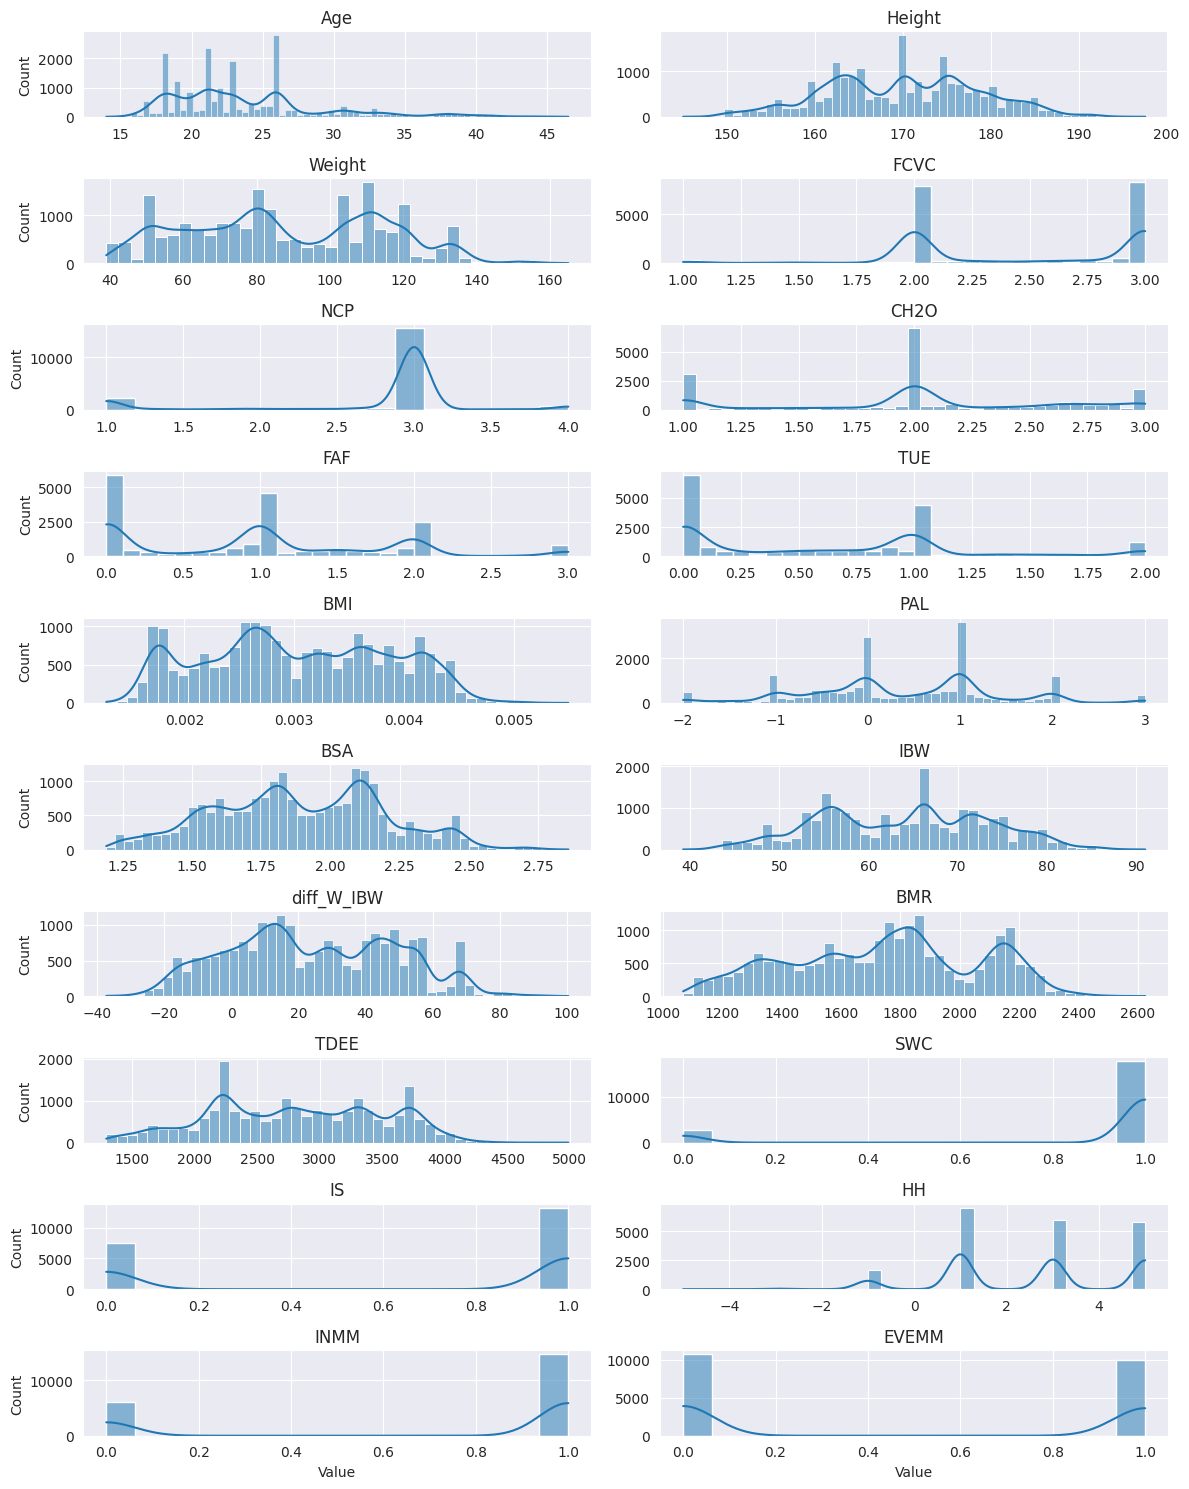

In [18]:
nrows = 10
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
r, c = 0, 0

fig.set_figwidth(12)
fig.set_figheight(15)

# plotting numerical columns distributions
numerical_columns = df.select_dtypes(exclude="object").columns.tolist()

for nc in numerical_columns:
    print(nc)
    if c == ncols:
        c = 0
        r += 1

    sns.histplot(
        data=df[nc],
        ax=axs[r, c],
        kde=True
    )

    axs[r, c].set_title(nc)
    axs[r, c].set_xlabel("")
    axs[r, c].set_ylabel("")

    if c == 0:
        axs[r, c].set_ylabel("Count")

    if (r == nrows - 1) or (r == nrows - 2 and c > 1):
        axs[r, c].set_xlabel("Value")

    c += 1

fig.tight_layout()
fig.show()

#### Transforming `Age` Column Into a Categorical Column

In [19]:
values, bins = pd.qcut(x=df["Age"], q=4, retbins=True, labels=["q1", "q2", "q3", "q4"])
bins = np.concatenate(([-np.inf], bins[1:-1], [np.inf]))

df["Age"] = values
df["Age"] = df["Age"].astype("object")
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,BSA,IBW,diff_W_IBW,BMR,TDEE,SWC,IS,HH,INMM,EVEMM
0,Male,q3,169.9998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,...,1.800435,66.19982,15.470130,1761.983195,2114.379834,1,1,1,0,0
1,Female,q1,156.0000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,...,1.463849,49.10000,7.900000,1294.000000,2458.600000,1,1,3,1,0
2,Female,q1,171.1460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,...,1.525607,62.73140,-12.565646,1320.320040,2046.496062,1,1,-1,0,1
3,Female,q2,171.0730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,...,2.373661,62.66570,68.609151,2116.191075,3650.429604,0,0,3,1,1
4,Male,q4,191.4186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,...,2.198526,85.47674,8.321315,1981.141395,3417.468906,1,0,5,0,1


#### Transforming `IS`, `SWC`, `EVEMM`, `INMM` into Categorical Columns

In [20]:
df["SWC"] = df["SWC"].astype("object")
df["IS"] = df["IS"].astype("object")
df["EVEMM"] = df["EVEMM"].astype("object")
df["INMM"] = df["INMM"].astype("object")
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,BSA,IBW,diff_W_IBW,BMR,TDEE,SWC,IS,HH,INMM,EVEMM
0,Male,q3,169.9998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,...,1.800435,66.19982,15.470130,1761.983195,2114.379834,1,1,1,0,0
1,Female,q1,156.0000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,...,1.463849,49.10000,7.900000,1294.000000,2458.600000,1,1,3,1,0
2,Female,q1,171.1460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,...,1.525607,62.73140,-12.565646,1320.320040,2046.496062,1,1,-1,0,1
3,Female,q2,171.0730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,...,2.373661,62.66570,68.609151,2116.191075,3650.429604,0,0,3,1,1
4,Male,q4,191.4186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,...,2.198526,85.47674,8.321315,1981.141395,3417.468906,1,0,5,0,1


#### Transforming `HH` Column Into a Categorical Column

In [21]:
df["HH"] = df["HH"].astype(int)
df["HH"] = pd.qcut(x=df["HH"], q=3, labels=["bad", "ok", "good"])
df["HH"] = df["HH"].astype("object")
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,BSA,IBW,diff_W_IBW,BMR,TDEE,SWC,IS,HH,INMM,EVEMM
0,Male,q3,169.9998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,...,1.800435,66.19982,15.470130,1761.983195,2114.379834,1,1,bad,0,0
1,Female,q1,156.0000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,...,1.463849,49.10000,7.900000,1294.000000,2458.600000,1,1,ok,1,0
2,Female,q1,171.1460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,...,1.525607,62.73140,-12.565646,1320.320040,2046.496062,1,1,bad,0,1
3,Female,q2,171.0730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,...,2.373661,62.66570,68.609151,2116.191075,3650.429604,0,0,ok,1,1
4,Male,q4,191.4186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,...,2.198526,85.47674,8.321315,1981.141395,3417.468906,1,0,good,0,1


#### Splitting the Data into Training and Validation Sets

In [22]:
X = df.drop(columns=["NObeyesdad"])
y = df["NObeyesdad"].values

X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.15,
    stratify=y,
    random_state=SEED
)

X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)

pprint(f"Train set shape: {X_train.shape} and {y_train.shape}")
pprint(f"Validation set shape: {X_valid.shape} and {y_valid.shape}")

'Train set shape: (17576, 28) and (17576,)'
'Validation set shape: (3102, 28) and (3102,)'


#### Transforming the Numerical Columns (Log Transformation)

In [23]:
numerical_columns = df.select_dtypes(exclude="object").columns.tolist()
epsilon = 1e-10

for nc in numerical_columns:
    if not nc in ["diff_W_IBW", "PAL"]:
        X_train[nc] = np.log(X_train[nc].values + epsilon)
        X_valid[nc] = np.log(X_valid[nc].values + epsilon)

#### Scaling the Numerical Columns

In [24]:
pprint("Training set skewness before scaling:")
pprint(X_train[numerical_columns].skew())
print()
pprint("Validation set skewness before scaling:")
pprint(X_valid[numerical_columns].skew())

'Training set skewness before scaling:'
Height       -0.094744
Weight       -0.374388
FCVC         -0.947213
NCP          -1.999068
CH2O         -0.778791
FAF          -1.161352
TUE          -0.774001
BMI          -0.366170
PAL           0.060291
BSA          -0.299765
IBW          -0.260906
diff_W_IBW    0.124600
BMR          -0.412550
TDEE         -0.526674
dtype: float64

'Validation set skewness before scaling:'
Height       -0.104261
Weight       -0.358742
FCVC         -1.079625
NCP          -2.050963
CH2O         -0.769114
FAF          -1.207402
TUE          -0.798383
BMI          -0.367036
PAL           0.056840
BSA          -0.285431
IBW          -0.263919
diff_W_IBW    0.111858
BMR          -0.391904
TDEE         -0.526370
dtype: float64


In [25]:
scalers = {}

for nc in numerical_columns:
    sc = StandardScaler()
    X_train[nc] = sc.fit_transform(X_train[nc].values.reshape(-1, 1))
    X_valid[nc] = sc.transform(X_valid[nc].values.reshape(-1, 1))
    scalers[nc] = sc

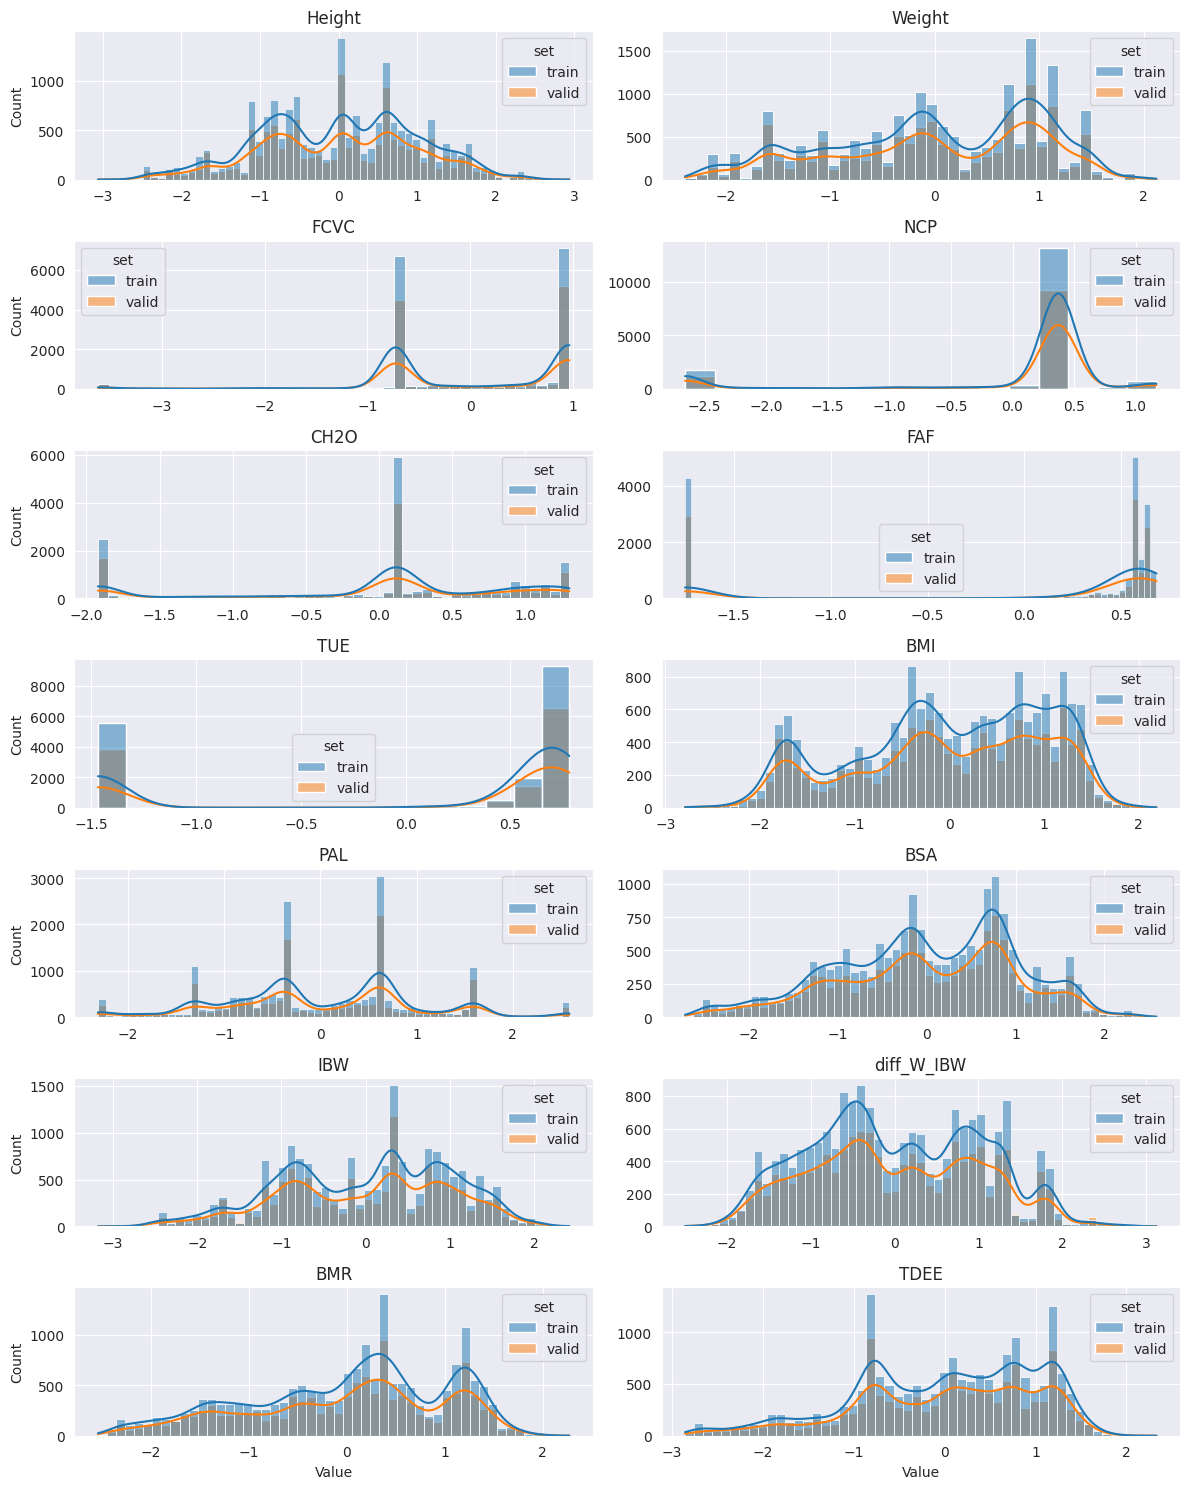

In [26]:
nrows = 7
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
r, c = 0, 0

fig.set_figwidth(12)
fig.set_figheight(15)

temp_train = X_train.copy()
temp_train["set"] = ["train"] * temp_train.shape[0]

temp_valid = X_valid.copy()
temp_valid["set"] = ["valid"] * temp_valid.shape[0]

temp = pd.concat(
    [temp_train, temp_valid, temp_valid, temp_valid, temp_valid],
    axis=0,
    ignore_index=True
)

for nc in numerical_columns:
    if c == ncols:
        c = 0
        r += 1

    sns.histplot(
        data=temp[[nc, "set"]],
        x=nc,
        hue="set",
        ax=axs[r, c],
        kde=True
    )

    axs[r, c].set_title(nc)
    axs[r, c].set_xlabel("")
    axs[r, c].set_ylabel("")

    if c == 0:
        axs[r, c].set_ylabel("Count")

    if (r == nrows - 1) or (r == nrows - 2 and c > 1):
        axs[r, c].set_xlabel("Value")

    c += 1

del temp, temp_train, temp_valid

fig.tight_layout()
fig.show()

In [27]:
pprint("Training set skewness after scaling:")
pprint(X_train[numerical_columns].skew())
print()
pprint("Validation set skewness after scaling:")
pprint(X_valid[numerical_columns].skew())

'Training set skewness after scaling:'
Height       -0.094744
Weight       -0.374388
FCVC         -0.947213
NCP          -1.999068
CH2O         -0.778791
FAF          -1.161352
TUE          -0.774001
BMI          -0.366170
PAL           0.060291
BSA          -0.299765
IBW          -0.260906
diff_W_IBW    0.124600
BMR          -0.412550
TDEE         -0.526674
dtype: float64

'Validation set skewness after scaling:'
Height       -0.104261
Weight       -0.358742
FCVC         -1.079625
NCP          -2.050963
CH2O         -0.769114
FAF          -1.207402
TUE          -0.798383
BMI          -0.367036
PAL           0.056840
BSA          -0.285431
IBW          -0.263919
diff_W_IBW    0.111858
BMR          -0.391904
TDEE         -0.526370
dtype: float64


#### Encoding the Categorical Columns

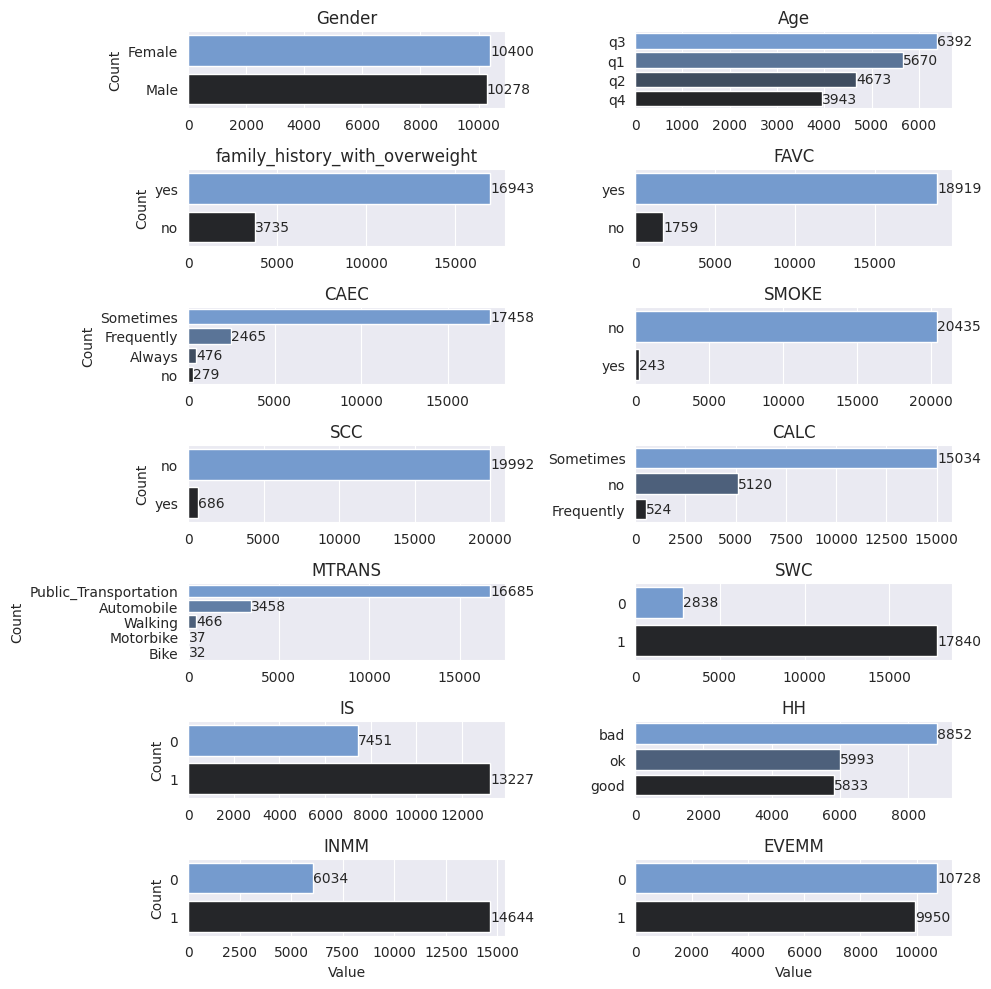

In [28]:
nrows = 7
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
r, c = 0, 0

fig.set_figwidth(10)
fig.set_figheight(10)

# plotting categorical columns distributions
categorical_columns = df.select_dtypes(include="object").columns.tolist()
target_column = "NObeyesdad"
categorical_columns.remove(target_column)

for cc in categorical_columns:
    if c == ncols:
        c = 0
        r += 1

    temp = df[cc].value_counts().reset_index()
    temp.columns = ["Value", "Count"]

    sns.barplot(
        data=temp,
        y="Value",
        x="Count",
        palette=sns.dark_palette("#69d", reverse=True, n_colors=temp.shape[0]),
        ax=axs[r, c],
        orient="h"
    )

    for i in axs[r, c].containers:
        axs[r, c].bar_label(i,)

    axs[r, c].set_title(cc)
    axs[r, c].set_xlabel("")
    axs[r, c].set_ylabel("")

    if c == 0:
        axs[r, c].set_ylabel("Count")

    if (r == nrows - 1) or (r == nrows - 2 and c > 1):
        axs[r, c].set_xlabel("Value")

    c += 1

fig.tight_layout()
fig.show()

In [29]:
new_train_df = pd.DataFrame()
new_valid_df = pd.DataFrame()

encoders = {}

for cc in categorical_columns:
    ohe = OneHotEncoder(
        drop="first",
        sparse_output=False,
        handle_unknown="infrequent_if_exist",
        min_frequency=20,
    )
    
    train_categorical_features = pd.DataFrame(
        ohe.fit_transform(X_train[cc].values.reshape(-1, 1)),
        columns=ohe.get_feature_names_out(),
    )
    train_categorical_features = train_categorical_features.add_prefix(cc + "_")
    new_train_df = pd.concat([new_train_df, train_categorical_features], axis=1)

    valid_categorical_features = pd.DataFrame(
        ohe.transform(X_valid[cc].values.reshape(-1, 1)),
        columns=ohe.get_feature_names_out(),
    )
    valid_categorical_features = valid_categorical_features.add_prefix(cc + "_")
    new_valid_df = pd.concat([new_valid_df, valid_categorical_features], axis=1)

    encoders[cc] = ohe

new_train_df = pd.concat([new_train_df, X_train.drop(columns=categorical_columns)], axis=1)
new_valid_df = pd.concat([new_valid_df, X_valid.drop(columns=categorical_columns)], axis=1)

X_train = new_train_df.values.copy()
X_valid = new_valid_df.values.copy()

#### Encoding the Labels

In [30]:
ohe_label = LabelBinarizer(
    sparse_output=False
)

original_y_train = y_train.copy()
original_y_valid = y_valid.copy()

y_train = ohe_label.fit_transform(y_train.reshape(-1, 1))
y_valid = ohe_label.transform(y_valid.reshape(-1, 1))

In [31]:
pprint(f"Train set shape: {X_train.shape} and {y_train.shape}")
pprint(f"Validation set shape: {X_valid.shape} and {y_valid.shape}")

'Train set shape: (17576, 37) and (17576, 7)'
'Validation set shape: (3102, 37) and (3102, 7)'


### Saving the Artifacts

In [32]:
# saving the artifacts locally
os.makedirs(ARTIFACTS_OUTPUT_PATH, exist_ok=True)
os.makedirs(FEATURES_OUTPUT_PATH, exist_ok=True)

joblib.dump(scalers, os.path.join(ARTIFACTS_OUTPUT_PATH, "features_sc.pkl"))
joblib.dump(encoders, os.path.join(ARTIFACTS_OUTPUT_PATH, "features_ohe.pkl"))
joblib.dump(ohe_label, os.path.join(ARTIFACTS_OUTPUT_PATH, "label_ohe.pkl"))
joblib.dump(bins, os.path.join(ARTIFACTS_OUTPUT_PATH, "qcut_bins.pkl"))

joblib.dump(X_train, os.path.join(FEATURES_OUTPUT_PATH, "X_train.pkl"))
joblib.dump(y_train, os.path.join(FEATURES_OUTPUT_PATH, "y_train.pkl"))
joblib.dump(X_valid, os.path.join(FEATURES_OUTPUT_PATH, "X_valid.pkl"))
joblib.dump(y_valid, os.path.join(FEATURES_OUTPUT_PATH, "y_valid.pkl"))

['/media/greca/HD/GitHub/e2e-mlops-project//models/features/y_valid.pkl']

In [33]:
# saving the preprocessed dataset locally
new_train_df[target_column] = original_y_train
new_valid_df[target_column] = original_y_valid

preprocessed_data = pd.concat([new_train_df, new_valid_df])
preprocessed_data.to_csv(PROCESSED_RAW_FILE_PATH, index=False, sep=",")

In [34]:
# sending the artifacts to the aws s3 bucket
def upload_folder_s3(root_path: str):
    try:
        for path, _, files in os.walk(root_path):
            directory_name = path.split("/")[-2]
            for file in files:
                s3.upload_file(os.path.join(path, file), credentials_config["S3"], os.path.join(directory_name, file))

    except Exception as err:
        print(err)

if credentials_config["S3"] != "YOUR_S3_BUCKET_URL":
    
    if os.path.exists(ARTIFACTS_OUTPUT_PATH):
        upload_folder_s3(ARTIFACTS_OUTPUT_PATH)

    if os.path.exists(FEATURES_OUTPUT_PATH):
        upload_folder_s3(FEATURES_OUTPUT_PATH)

    # sending preprocessed dataset saved locally to the aws s3 bucket
    s3.upload_file(
        PROCESSED_RAW_FILE_PATH,
        credentials_config["S3"],
        PROCESSED_RAW_FILE
    )

    # removing downloaded dataset from local
    os.remove(RAW_FILE_PATH)
    os.remove(PROCESSED_RAW_FILE_PATH)

    # removing the local artifacts and features
    shutil.rmtree(ARTIFACTS_OUTPUT_PATH)
    shutil.rmtree(FEATURES_OUTPUT_PATH)